In [16]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D
from keras.metrics import Recall, Precision, BinaryAccuracy
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers, regularizers

import sklearn

import os
import cv2

# Loading Data
data is split into two fire and no-fire folders, with equal number of images in each

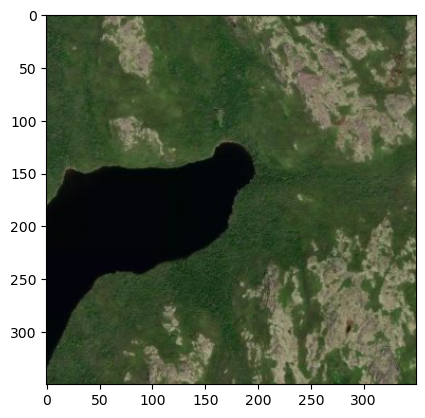

In [17]:
file_path_ex = os.path.join('train', 'wildfire', '-57.8088,51.44634.jpg')
ex_img = cv2.imread(file_path_ex)
plt.imshow(cv2.cvtColor(ex_img, cv2.COLOR_BGR2RGB))
plt.show()

In [18]:
batch_size = 64 

# rescales the color
train_gen = ImageDataGenerator(dtype='float32', rescale= 1.0/255.0)
train = train_gen.flow_from_directory('train', target_size=(350, 350), batch_size=batch_size)
val_gen = ImageDataGenerator(dtype='float32', rescale= 1.0/255.0)
val = val_gen.flow_from_directory('valid', target_size=(350, 350), batch_size=batch_size)
test_gen = ImageDataGenerator(dtype='float32', rescale= 1.0/255.0)
test = test_gen.flow_from_directory('test', target_size=(350, 350), batch_size=batch_size)


Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.


In [19]:
print(str(len(train)) + " training batches + " + str(len(val)) + " validation batches + " + str(len(test)) + " testing batches")

473 training batches + 99 validation batches + 99 testing batches


In [20]:
ex_batch = train.next()
ex_batch

(array([[[[0.64705884, 0.65882355, 0.62352943],
          [0.02745098, 0.03921569, 0.01176471],
          [0.01960784, 0.03921569, 0.01568628],
          ...,
          [0.3921569 , 0.4156863 , 0.3137255 ],
          [0.3372549 , 0.37254903, 0.2509804 ],
          [0.10588236, 0.14901961, 0.01568628]],
 
         [[0.64705884, 0.67058825, 0.62352943],
          [0.07450981, 0.09803922, 0.0509804 ],
          [0.00392157, 0.02745098, 0.        ],
          ...,
          [0.21960786, 0.227451  , 0.13333334],
          [0.3372549 , 0.3529412 , 0.24705884],
          [0.10980393, 0.12941177, 0.00392157]],
 
         [[0.44705886, 0.47450984, 0.4039216 ],
          [0.12156864, 0.15686275, 0.09019608],
          [0.0627451 , 0.09411766, 0.03529412],
          ...,
          [0.10980393, 0.09019608, 0.01176471],
          [0.39607847, 0.37647063, 0.2901961 ],
          [0.2392157 , 0.23137257, 0.13333334]],
 
         ...,
 
         [[0.30980393, 0.3647059 , 0.23529413],
          [0.27843

In [21]:
ex_batch[0].shape

(64, 350, 350, 3)

[0. 1.]


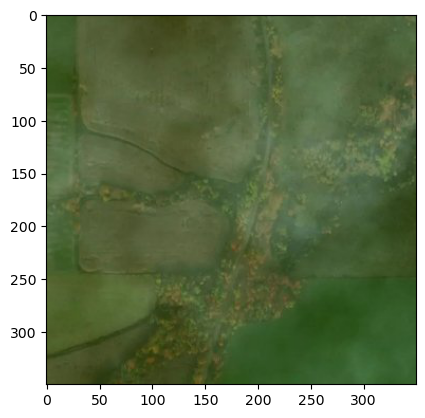

In [22]:
plt.imshow(ex_batch[0][6])
print(ex_batch[1][6])

/Users/etiennecasanova/anaconda3/lib/python3.11/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


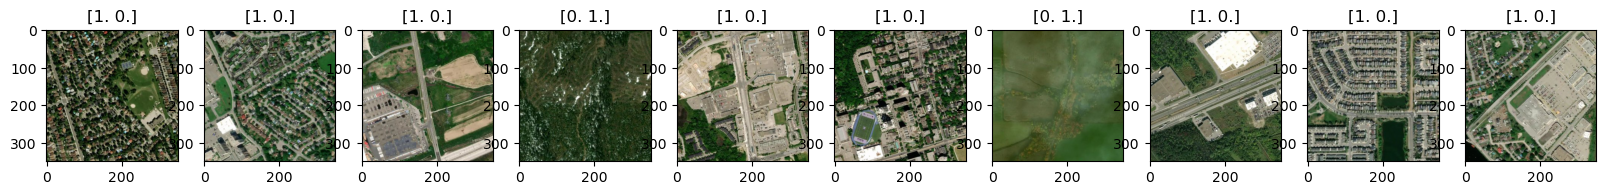

In [23]:
# check that the batches have been properly configured
fig, ax = plt.subplots(ncols = 10, figsize = (20, 20), nrows = 1)
for idx, img in enumerate(ex_batch[0][:10]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(ex_batch[1][idx])

first elem is no wild fire (when 1.), second element is wild fire (when 1.)

# Building model

In [24]:
weight_decay = 0.005
model = Sequential([
    Conv2D(8, (3,3), activation='relu', input_shape= (350, 350, 3)),
    MaxPooling2D(pool_size = 2),
    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D(pool_size = 2),
    Conv2D(32, (3,3), activation='relu', kernel_regularizer = regularizers.l2(weight_decay)),
    # prevent overfitting
    MaxPooling2D(pool_size = 2),
    # remove dimensions
    Flatten(),
    Dropout(0.4), 
    Dense(250, activation='relu'),
    Dropout(0.4),
    Dense(2, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 348, 348, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 174, 174, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 172, 172, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 86, 86, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 84, 84, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 42, 42, 32)       0

In [25]:
# adam defaults to 0.001 learning rate
# categorical crossentropy instead of binary
model.compile('adam', loss='categorical_crossentropy', metrics = ['accuracy'])

# Training

In [26]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5)
callback = tf.keras.callbacks.TensorBoard('logs')

In [27]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
# fixing data corruption bug
checkpoint = ModelCheckpoint(os.path.join('model','best_model.h5'), monitor='val_accuracy', save_best_only=True)
hist = model.fit(train, epochs = 15, validation_data = val, callbacks = [callback, early_stopping])

Epoch 1/15


2023-09-25 21:16:51.493620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-09-25 21:16:51.520671: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


473/473 [==============================] - ETA: 0s - loss: 0.2706 - accuracy: 0.9151

2023-09-25 21:21:36.944760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


473/473 [==============================] - 304s 641ms/step - loss: 0.2706 - accuracy: 0.9151 - val_loss: 0.1923 - val_accuracy: 0.9408
Epoch 2/15
473/473 [==============================] - 293s 619ms/step - loss: 0.1944 - accuracy: 0.9376 - val_loss: 0.2292 - val_accuracy: 0.9129
Epoch 3/15
473/473 [==============================] - 292s 617ms/step - loss: 0.1566 - accuracy: 0.9487 - val_loss: 0.1451 - val_accuracy: 0.9543
Epoch 4/15
473/473 [==============================] - 289s 611ms/step - loss: 0.1364 - accuracy: 0.9540 - val_loss: 0.1330 - val_accuracy: 0.9578
Epoch 5/15
473/473 [==============================] - 292s 618ms/step - loss: 0.1260 - accuracy: 0.9579 - val_loss: 0.1162 - val_accuracy: 0.9629
Epoch 6/15
473/473 [==============================] - 289s 611ms/step - loss: 0.1046 - accuracy: 0.9663 - val_loss: 0.1257 - val_accuracy: 0.9610
Epoch 7/15
473/473 [==============================] - 286s 604ms/step - loss: 0.0936 - accuracy: 0.9712 - val_loss: 0.1684 - val_accura

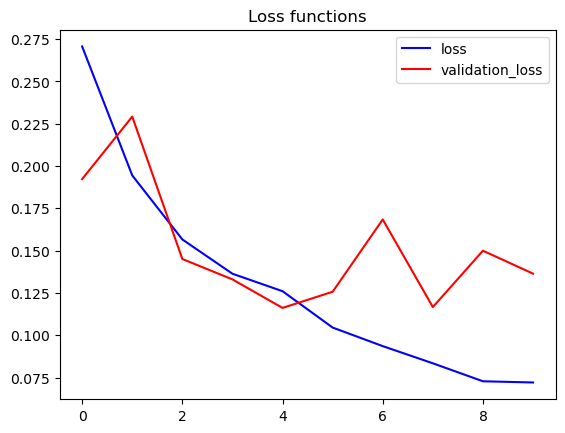

In [28]:
plt.plot(hist.history['loss'], label = 'loss', color='blue')
plt.plot(hist.history['val_loss'], label = 'validation_loss', color = 'red')
plt.title("Loss functions")
plt.legend()
plt.show()

appears we may have been slightly overfitting at some point in the epochs, but doesn't affect overall accuracy

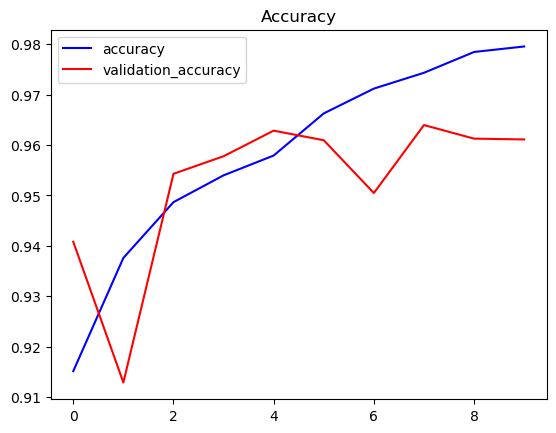

In [29]:
plt.plot(hist.history['accuracy'], label = 'accuracy', color='blue')
plt.plot(hist.history['val_accuracy'], label = 'validation_accuracy', color = 'red')
plt.title("Accuracy")
plt.legend()
plt.show()

In [32]:
model.save(os.path.join('models', 'satellite_fire_detection_model.h5'))

Test performance

2/2 [==============================] - 0s 82ms/step


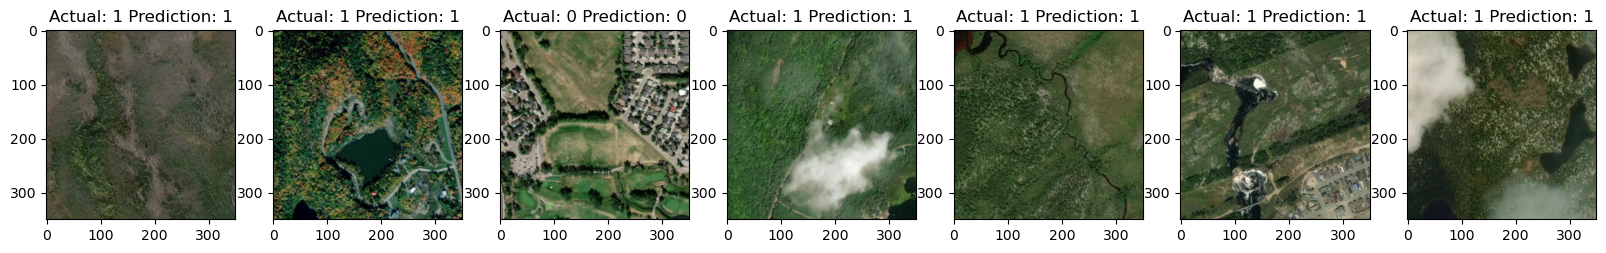

In [74]:
images, label = test.next()
y_hat = model.predict(images)
fig, ax = plt.subplots(ncols = 7, figsize = (20, 20))

for i in range(7):
    ax[i].imshow(images[i])
    ax[i].set_title('Actual: ' + str(np.argmax(label[i])) + ' Prediction: ' + str(np.argmax(y_hat[i])))
plt.show()

Predictions all correct for sample test data

In [75]:
# load in model
# Saved model is too big for github, so not available on repo
saved_model = load_model(os.path.join('models', 'satellite_fire_detection_model.h5'))

2/2 [==============================] - 0s 82ms/step


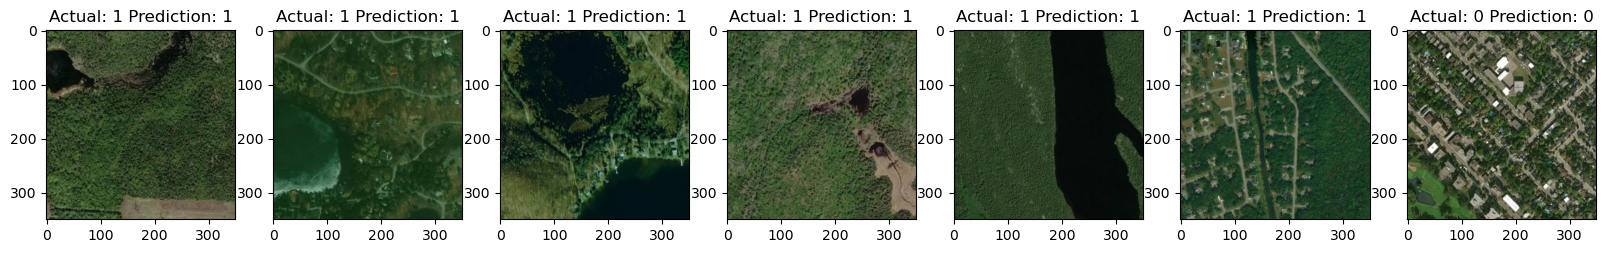

In [76]:
images, label = test.next()
y_hat = saved_model.predict(images)
fig, ax = plt.subplots(ncols = 7, figsize = (20, 20))

for i in range(7):
    ax[i].imshow(images[i])
    ax[i].set_title('Actual: ' + str(np.argmax(label[i])) + ' Prediction: ' + str(np.argmax(y_hat[i])))
plt.show()